<a href="https://colab.research.google.com/github/MiloCoombs2002/Final-Year-Project/blob/main/DNN_Trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install torch
!pip install pandas
!pip install numpy
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Fetch the data and preprocess
ticker = "MSFT"
msft_data = yf.download(ticker, start="2020-01-01")

# Calculate 30-day EMA
msft_data['30-Day EMA'] = msft_data['Close'].ewm(span=30, adjust=False).mean()

# RSI calculation function
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain.flatten(), index=series.index).rolling(window=period).mean()
    avg_loss = pd.Series(loss.flatten(), index=series.index).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

msft_data['RSI'] = calculate_rsi(msft_data['Close'], period=14)

# Calculate 20-day price change
msft_data['20-Day Change'] = msft_data['Close'] - msft_data['Close'].shift(20)

# Drop missing values
msft_data = msft_data.dropna()

# Step 2: Select features and target
features = msft_data[['Volume', 'RSI', '30-Day EMA', 'Close']]
target = msft_data['20-Day Change']

# Normalise features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to tensors
X = torch.tensor(features_scaled, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

# Initialise the model
input_size = X_train.shape[1]
model = DNN(input_size)

# Step 4: Define loss function and optimiser
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the model
epochs = 100
losses = []
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    losses.append(loss.item())
# Step 6: Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# Step 7: Example prediction
example_features = X_test[:5]
example_pred = model(example_features)
print("Example Predictions:", example_pred)
print("Actual Values:", y_test[:5])


[*********************100%***********************]  1 of 1 completed


Epoch 10/100, Loss: 363.3461
Epoch 20/100, Loss: 351.4637
Epoch 30/100, Loss: 326.9081
Epoch 40/100, Loss: 283.4662
Epoch 50/100, Loss: 220.6561
Epoch 60/100, Loss: 157.2736
Epoch 70/100, Loss: 128.9726
Epoch 80/100, Loss: 123.6489
Epoch 90/100, Loss: 121.4115
Epoch 100/100, Loss: 119.0516
Test Loss: 123.4560
Example Predictions: tensor([[  4.4794],
        [-14.7757],
        [-23.1979],
        [-10.0401],
        [ 35.1193]], grad_fn=<AddmmBackward0>)
Actual Values: tensor([[  3.0724],
        [-14.7700],
        [-31.9306],
        [ -6.7953],
        [ 23.5902]])


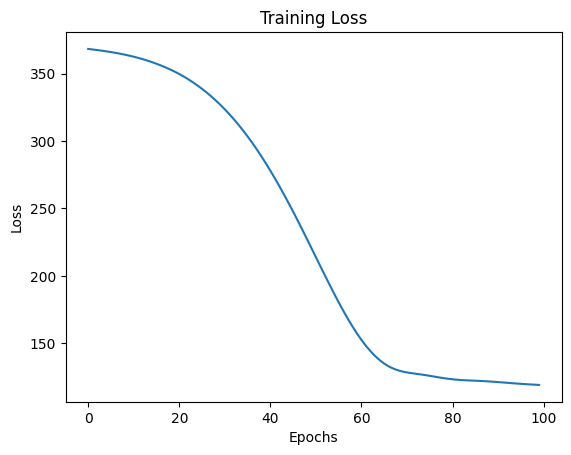

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

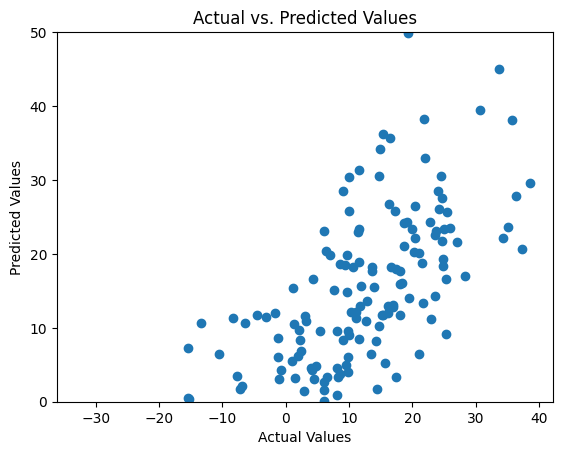

In [14]:
plt.scatter(model(X_test).detach().numpy(), y_test.detach().numpy())
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.ylim(0,50)
plt.show()